The network predicts quality scores for the individual repetitions for Exercise 1 - Deep Squat. The input to the network are the raw measurement data with 117 dimensions.

In [1]:
# Import libraries and functions

from __future__ import print_function
import numpy as np
np.random.seed(1337)  # for reproducibility

import csv
import os,random

# The code is run on a CPU

from keras.models import Model
from keras.layers import Input, Conv1D, LSTM, Dense, Dropout, Activation, Flatten, concatenate, UpSampling1D
from keras.callbacks import EarlyStopping
from keras.optimizers import *
from keras.layers import Lambda

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics import mean_squared_error
from math import sqrt

import datetime
now = datetime.datetime.now

In [2]:
timesteps = 240  # number of timesteps
nr = 90   # number of repetitions
n_dim = 117  # dimension of the data sequences

In [3]:
import DataViconLoad   # Import the data
Correct_data, Correct_label, Incorrect_data, Incorrect_label = DataViconLoad.load_data()

# Print the size of the data 
print(Correct_data.shape, 'correct sequences')
print(Correct_label.shape, 'correct labels')
print(Incorrect_data.shape, 'incorrect sequences')
print(Incorrect_label.shape, 'incorrect labels')

(90, 240, 117) correct sequences
(90, 1) correct labels
(90, 240, 117) incorrect sequences
(90, 1) incorrect labels


In [ ]:
len(Correct_data[0])

In [4]:
# Split the data into training and validation sets
# Training set: 70%
# Validation set: 30%

# Sample random indices
trainidx1 = random.sample(range(0,Correct_data.shape[0]),int(nr*0.7))
trainidx2 = random.sample(range(0,Incorrect_data.shape[0]),int(nr*0.7))
valididx1 = np.setdiff1d(np.arange(0,nr,1),trainidx1)
valididx2 = np.setdiff1d(np.arange(0,nr,1),trainidx2)

# Training set: data and labels
train_x = np.concatenate((Correct_data[trainidx1,:,:],Incorrect_data[trainidx2,:,:]))
print(train_x.shape, 'training data')
train_y = np.concatenate((np.squeeze(Correct_label[trainidx1]),np.squeeze(Incorrect_label[trainidx2])))
print(train_y.shape, 'training labels')

# Validation set: data and labels
valid_x = np.concatenate((Correct_data[valididx1,:,:],Incorrect_data[valididx2,:,:]))
print(valid_x.shape, 'validation data')
valid_y = np.concatenate((np.squeeze(Correct_label[valididx1]),np.squeeze(Incorrect_label[valididx2])))
print(valid_y.shape, 'validation labels')

(124, 240, 117) training data
(124,) training labels
(56, 240, 117) validation data
(56,) validation labels


In [ ]:
train_x.ndim

In [5]:
from tcn import TCN
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential

#tcn_layer = TCN(input_shape=(timesteps, n_dim))
tcn_layer = TCN(input_shape=(timesteps, n_dim), nb_filters=56,kernel_size=3,nb_stacks=1,dilations=(1, 2, 4, 8, 16, 32),
    padding='causal',use_skip_connections=True,dropout_rate=0.01,return_sequences=True,
    activation='relu',kernel_initializer='he_normal',use_batch_norm=False,use_layer_norm=False,use_weight_norm=False)
# The receptive field tells you how far the model can see in terms of timesteps.

tcn_layer_1 = TCN(nb_filters=20,kernel_size=3,nb_stacks=1,dilations=(1, 2, 4, 8, 16),
    padding='causal',use_skip_connections=True,dropout_rate=0.01,return_sequences=True,
    activation='relu',kernel_initializer='he_normal',use_batch_norm=False,use_layer_norm=False,use_weight_norm=False)

tcn_layer_2 = TCN(nb_filters=10,kernel_size=3,nb_stacks=1,dilations=(1, 2, 4, 8),
    padding='causal',use_skip_connections=True,dropout_rate=0.01,return_sequences=False,
    activation='relu',kernel_initializer='he_normal',use_batch_norm=False,use_layer_norm=False,use_weight_norm=False)


In [6]:
m = Sequential([
    tcn_layer,
    tcn_layer_1,
    tcn_layer_2,
    Dense(1)
])

m.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 tcn (TCN)                   (None, 240, 56)           130424    
                                                                 
 tcn_1 (TCN)                 (None, 240, 20)           15500     
                                                                 
 tcn_2 (TCN)                 (None, 10)                2990      
                                                                 
 dense (Dense)               (None, 1)                 11        
                                                                 
Total params: 148,925
Trainable params: 148,925
Non-trainable params: 0
_________________________________________________________________


In [7]:
m.compile(optimizer=Adam(learning_rate=0.0001), loss='mse')

#tcn_full_summary(m, expand_residual_blocks=False)


#m.fit(train_x, train_y, epochs=10, validation_split=0.2)

t = now()
    
early_stopping = EarlyStopping(monitor='val_loss', patience = 25)

history = m.fit(train_x, train_y, batch_size=10, epochs=500, verbose=0, 
                validation_data=(valid_x, valid_y), callbacks = [early_stopping])

print('Training time: %s' % (now() - t))

Training time: 0:06:39.408875


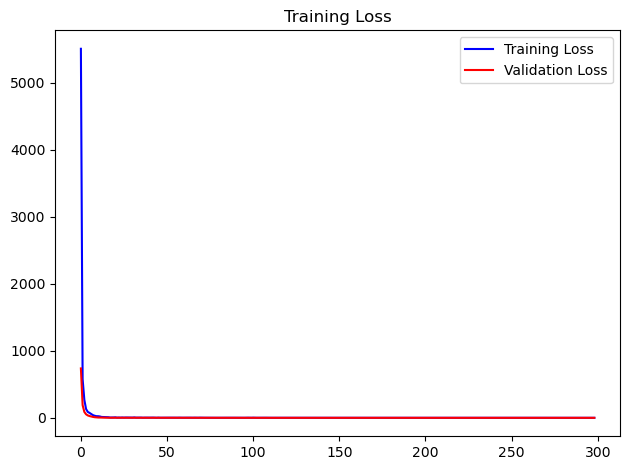

Training loss 0.09881407767534256
Validation loss 0.048042379319667816


In [8]:
# Plot the results
plt.figure(1)
plt.plot(history.history['loss'], 'b', label = 'Training Loss')
plt.title('Training Loss')
plt.plot(history.history['val_loss'], 'r', label = 'Validation Loss')
plt.legend()
plt.tight_layout()
plt.show()
# Print the minimum loss
print("Training loss", np.min(history.history['loss']))
print("Validation loss",np.min(history.history['val_loss']))    

2/2 [==============================] - 0s 67ms/step


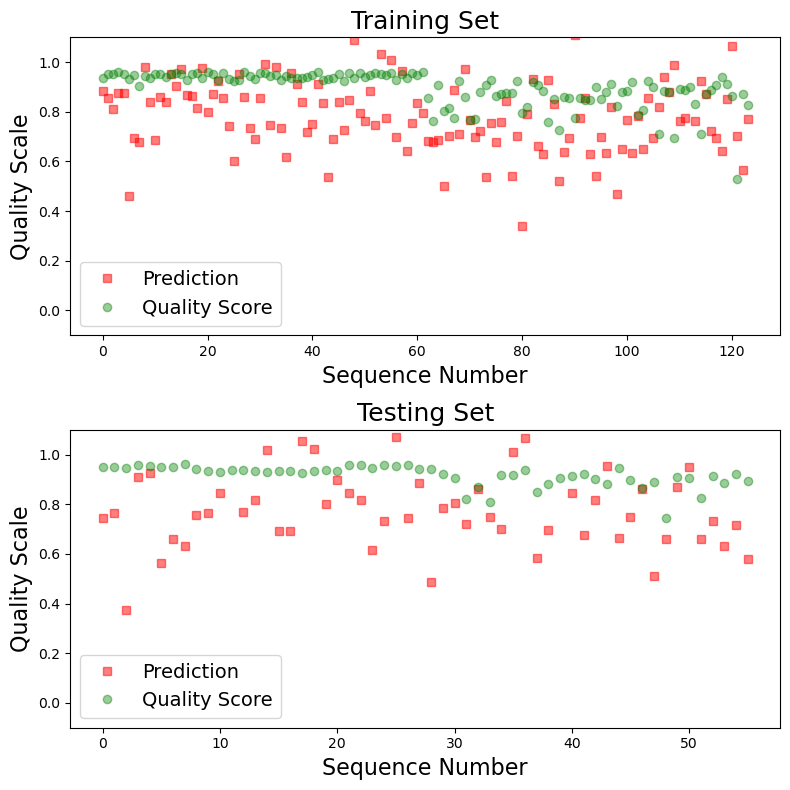

In [9]:
# Plot the prediction of the model for the training and validation sets
pred_train = m.predict(train_x)

pred_test = m.predict(valid_x)

plt.figure(figsize = (8,8))
plt.subplot(2,1,1)
plt.plot(pred_train,'s', color='red', label='Prediction', linestyle='None', alpha = 0.5, markersize=6)
plt.plot(train_y,'o', color='green',label='Quality Score', alpha = 0.4, markersize=6)
plt.ylim([-0.1,1.1])
plt.title('Training Set',fontsize=18)
plt.xlabel('Sequence Number',fontsize=16)
plt.ylabel('Quality Scale',fontsize=16)
plt.legend(loc=3, prop={'size':14}) # loc:position
plt.subplot(2,1,2)
plt.plot(pred_test,'s', color='red', label='Prediction', linestyle='None', alpha = 0.5, markersize=6)
plt.plot(valid_y,'o', color='green',label='Quality Score', alpha = 0.4, markersize=6)
plt.title('Testing Set',fontsize=18)
plt.ylim([-0.1,1.1])
plt.xlabel('Sequence Number',fontsize=16)
plt.ylabel('Quality Scale',fontsize=16)
plt.legend(loc=3, prop={'size':14}) # loc:position
plt.tight_layout()
plt.savefig('../../Results/SpatioTemporalNN_Vicon_Scores.png', dpi=300)
plt.show()

In [10]:
# Calculate the cumulative deviation and rms deviation for the validation set
test_dev = abs(np.squeeze(pred_test)-valid_y)
# Cumulative deviation
mean_abs_dev = np.mean(test_dev)
# RMS deviation
rms_dev = sqrt(mean_squared_error(pred_test, valid_y))
print('Mean absolute deviation:', mean_abs_dev)
print('RMS deviation:', rms_dev)

Mean absolute deviation: 0.18394953216178075
RMS deviation: 0.23175017744362375
